In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
num_steps_train_discriminator = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/train-labels-idx1-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-images-idx3-ubyte.gz to input/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting input/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to input/data/MNIST/raw



# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [14]:
torch.manual_seed(7777)

def generator_loss(generator_output):
    ############ YOUR CODE HERE ##########
     gen_disc_output = discriminator(generator_output)
     loss = criterion(gen_disc_output, label_real(len(gen_disc_output)))
     return loss
    
    
    ######################################
    
def discriminator_loss(discriminator_output_fake, discriminator_output_true):
    ############ YOUR CODE HERE ##########
    loss_fake = criterion(discriminator_output_fake, label_fake(len(discriminator_output_fake)))
    loss_real = criterion(discriminator_output_true, label_real(len(discriminator_output_true)))
    
    return loss_fake, loss_real
    
    ######################################

# Q. Write training loop

118it [00:52,  2.27it/s]


Epoch 1 of 100
Generator loss: 1.28773305, Discriminator loss: 0.91063098


118it [00:50,  2.33it/s]


Epoch 2 of 100
Generator loss: 2.91040030, Discriminator loss: 1.24539871


118it [00:51,  2.28it/s]


Epoch 3 of 100
Generator loss: 3.99983244, Discriminator loss: 0.50220282


118it [00:51,  2.29it/s]


Epoch 4 of 100
Generator loss: 3.82621674, Discriminator loss: 0.67686423


118it [00:52,  2.27it/s]


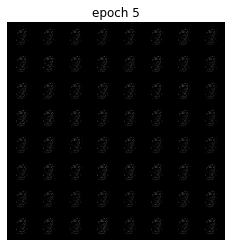

Epoch 5 of 100
Generator loss: 2.88688218, Discriminator loss: 0.87886989


118it [00:52,  2.26it/s]


Epoch 6 of 100
Generator loss: 1.86387667, Discriminator loss: 1.03885608


118it [00:53,  2.22it/s]


Epoch 7 of 100
Generator loss: 1.34147313, Discriminator loss: 1.31944646


118it [00:53,  2.19it/s]


Epoch 8 of 100
Generator loss: 1.22754964, Discriminator loss: 0.94611496


118it [00:52,  2.23it/s]


Epoch 9 of 100
Generator loss: 2.50837547, Discriminator loss: 0.92235583


118it [00:52,  2.23it/s]


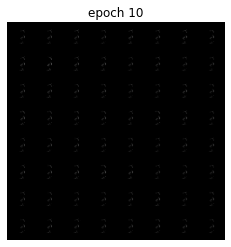

Epoch 10 of 100
Generator loss: 1.26475354, Discriminator loss: 0.97698337


118it [00:52,  2.24it/s]


Epoch 11 of 100
Generator loss: 1.14314852, Discriminator loss: 1.25281633


118it [00:53,  2.20it/s]


Epoch 12 of 100
Generator loss: 1.48784778, Discriminator loss: 0.93572872


118it [00:52,  2.25it/s]


Epoch 13 of 100
Generator loss: 2.61160205, Discriminator loss: 0.62058297


118it [00:52,  2.25it/s]


Epoch 14 of 100
Generator loss: 3.68174416, Discriminator loss: 0.68159910


118it [00:52,  2.23it/s]


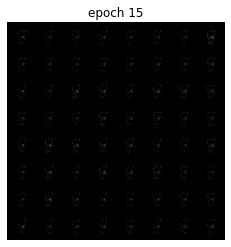

Epoch 15 of 100
Generator loss: 2.70876664, Discriminator loss: 0.72497750


118it [00:53,  2.20it/s]


Epoch 16 of 100
Generator loss: 3.85610714, Discriminator loss: 0.57321089


118it [00:54,  2.18it/s]


Epoch 17 of 100
Generator loss: 2.89078983, Discriminator loss: 0.71224410


118it [00:52,  2.25it/s]


Epoch 18 of 100
Generator loss: 2.68901909, Discriminator loss: 0.75893980


118it [00:52,  2.25it/s]


Epoch 19 of 100
Generator loss: 2.88663254, Discriminator loss: 0.52791846


118it [00:52,  2.25it/s]


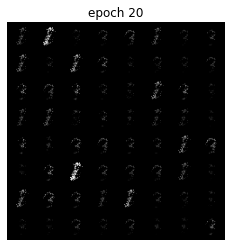

Epoch 20 of 100
Generator loss: 3.44129657, Discriminator loss: 0.46801054


118it [00:53,  2.22it/s]


Epoch 21 of 100
Generator loss: 2.58455283, Discriminator loss: 0.63675582


118it [00:52,  2.27it/s]


Epoch 22 of 100
Generator loss: 3.06866069, Discriminator loss: 0.53194904


118it [00:51,  2.27it/s]


Epoch 23 of 100
Generator loss: 2.80712292, Discriminator loss: 0.54763441


118it [00:52,  2.26it/s]


Epoch 24 of 100
Generator loss: 2.90048406, Discriminator loss: 0.57364427


118it [00:52,  2.26it/s]


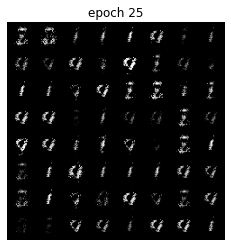

Epoch 25 of 100
Generator loss: 2.60923217, Discriminator loss: 0.56021443


118it [00:53,  2.22it/s]


Epoch 26 of 100
Generator loss: 3.15438987, Discriminator loss: 0.47991281


118it [00:51,  2.28it/s]


Epoch 27 of 100
Generator loss: 2.78152325, Discriminator loss: 0.58784692


118it [00:51,  2.27it/s]


Epoch 28 of 100
Generator loss: 2.91924608, Discriminator loss: 0.52468252


118it [00:51,  2.29it/s]


Epoch 29 of 100
Generator loss: 2.94991337, Discriminator loss: 0.45989132


118it [00:53,  2.20it/s]


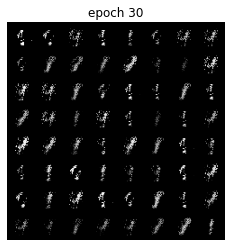

Epoch 30 of 100
Generator loss: 3.10125723, Discriminator loss: 0.46838415


118it [00:53,  2.22it/s]


Epoch 31 of 100
Generator loss: 3.13671293, Discriminator loss: 0.54778485


118it [00:53,  2.21it/s]


Epoch 32 of 100
Generator loss: 2.89051760, Discriminator loss: 0.48095852


118it [00:53,  2.22it/s]


Epoch 33 of 100
Generator loss: 2.93221588, Discriminator loss: 0.51315904


118it [00:52,  2.25it/s]


Epoch 34 of 100
Generator loss: 2.53550195, Discriminator loss: 0.64026137


118it [00:52,  2.25it/s]


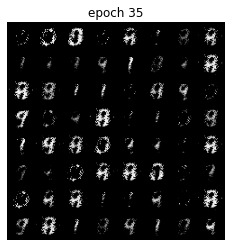

Epoch 35 of 100
Generator loss: 2.63709215, Discriminator loss: 0.60145037


118it [00:52,  2.27it/s]


Epoch 36 of 100
Generator loss: 2.53818374, Discriminator loss: 0.55249033


118it [00:51,  2.31it/s]


Epoch 37 of 100
Generator loss: 2.95054710, Discriminator loss: 0.45064092


118it [00:50,  2.35it/s]


Epoch 38 of 100
Generator loss: 3.01092722, Discriminator loss: 0.46675620


118it [00:50,  2.32it/s]


Epoch 39 of 100
Generator loss: 3.11029617, Discriminator loss: 0.47772794


118it [00:50,  2.35it/s]


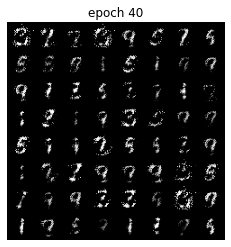

Epoch 40 of 100
Generator loss: 2.64813730, Discriminator loss: 0.57220440


118it [00:50,  2.34it/s]


Epoch 41 of 100
Generator loss: 3.10346647, Discriminator loss: 0.46953803


118it [00:50,  2.32it/s]


Epoch 42 of 100
Generator loss: 3.02000417, Discriminator loss: 0.51522642


118it [00:52,  2.25it/s]


Epoch 43 of 100
Generator loss: 2.66848032, Discriminator loss: 0.58695460


118it [00:51,  2.31it/s]


Epoch 44 of 100
Generator loss: 2.74503063, Discriminator loss: 0.52998570


118it [00:50,  2.32it/s]


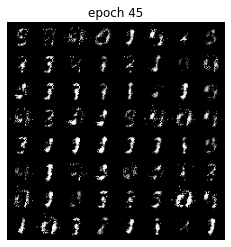

Epoch 45 of 100
Generator loss: 2.97762703, Discriminator loss: 0.52187218


118it [00:50,  2.33it/s]


Epoch 46 of 100
Generator loss: 2.92229638, Discriminator loss: 0.50463312


118it [00:51,  2.27it/s]


Epoch 47 of 100
Generator loss: 2.80513313, Discriminator loss: 0.58196072


118it [00:52,  2.25it/s]


Epoch 48 of 100
Generator loss: 2.75155940, Discriminator loss: 0.50064514


118it [00:51,  2.30it/s]


Epoch 49 of 100
Generator loss: 2.71416455, Discriminator loss: 0.54038979


118it [00:50,  2.33it/s]


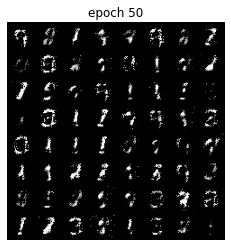

Epoch 50 of 100
Generator loss: 2.68019993, Discriminator loss: 0.60634074


118it [00:50,  2.35it/s]


Epoch 51 of 100
Generator loss: 2.58725054, Discriminator loss: 0.57889056


118it [00:55,  2.14it/s]


Epoch 52 of 100
Generator loss: 2.49423918, Discriminator loss: 0.60836361


118it [00:51,  2.29it/s]


Epoch 53 of 100
Generator loss: 2.54302877, Discriminator loss: 0.57386062


118it [00:52,  2.26it/s]


Epoch 54 of 100
Generator loss: 2.31769652, Discriminator loss: 0.67171983


118it [00:49,  2.37it/s]


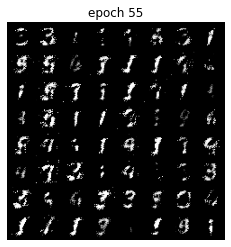

Epoch 55 of 100
Generator loss: 2.58521374, Discriminator loss: 0.63591425


118it [00:50,  2.35it/s]


Epoch 56 of 100
Generator loss: 2.46303850, Discriminator loss: 0.63798706


118it [00:50,  2.36it/s]


Epoch 57 of 100
Generator loss: 2.40038435, Discriminator loss: 0.64274450


118it [00:53,  2.21it/s]


Epoch 58 of 100
Generator loss: 2.31634333, Discriminator loss: 0.65944407


118it [00:53,  2.22it/s]


Epoch 59 of 100
Generator loss: 2.32045300, Discriminator loss: 0.65867092


118it [00:52,  2.23it/s]


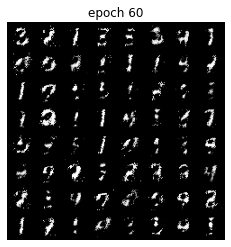

Epoch 60 of 100
Generator loss: 2.31516116, Discriminator loss: 0.66938017


118it [00:53,  2.22it/s]


Epoch 61 of 100
Generator loss: 2.42695163, Discriminator loss: 0.63764501


118it [00:53,  2.20it/s]


Epoch 62 of 100
Generator loss: 2.32248074, Discriminator loss: 0.70265106


118it [00:51,  2.27it/s]


Epoch 63 of 100
Generator loss: 2.17434442, Discriminator loss: 0.71267035


118it [00:51,  2.27it/s]


Epoch 64 of 100
Generator loss: 2.24023403, Discriminator loss: 0.68936018


118it [00:53,  2.20it/s]


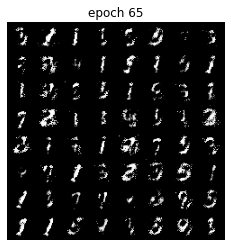

Epoch 65 of 100
Generator loss: 2.23452493, Discriminator loss: 0.69320163


118it [00:53,  2.21it/s]


Epoch 66 of 100
Generator loss: 2.46099624, Discriminator loss: 0.65078028


118it [00:54,  2.15it/s]


Epoch 67 of 100
Generator loss: 2.49309648, Discriminator loss: 0.68871069


118it [00:54,  2.16it/s]


Epoch 68 of 100
Generator loss: 2.15874045, Discriminator loss: 0.77499902


118it [00:53,  2.22it/s]


Epoch 69 of 100
Generator loss: 2.19684359, Discriminator loss: 0.73323416


118it [00:53,  2.22it/s]


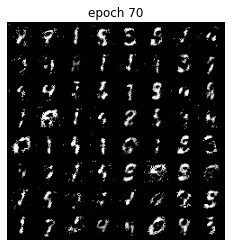

Epoch 70 of 100
Generator loss: 2.38016495, Discriminator loss: 0.65846247


118it [00:55,  2.13it/s]


Epoch 71 of 100
Generator loss: 2.30694864, Discriminator loss: 0.73963644


118it [00:52,  2.26it/s]


Epoch 72 of 100
Generator loss: 2.24986911, Discriminator loss: 0.71895435


118it [00:54,  2.16it/s]


Epoch 73 of 100
Generator loss: 2.27879176, Discriminator loss: 0.71193725


118it [00:54,  2.18it/s]


Epoch 74 of 100
Generator loss: 2.29278597, Discriminator loss: 0.71731522


118it [00:55,  2.14it/s]


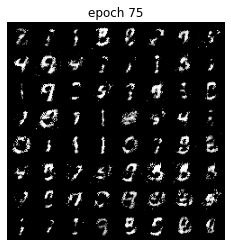

Epoch 75 of 100
Generator loss: 2.44297407, Discriminator loss: 0.65724429


118it [00:54,  2.17it/s]


Epoch 76 of 100
Generator loss: 2.27940041, Discriminator loss: 0.69769725


118it [00:54,  2.18it/s]


Epoch 77 of 100
Generator loss: 2.27780765, Discriminator loss: 0.70029454


118it [00:54,  2.15it/s]


Epoch 78 of 100
Generator loss: 2.36608752, Discriminator loss: 0.66843670


118it [00:53,  2.19it/s]


Epoch 79 of 100
Generator loss: 2.36979893, Discriminator loss: 0.67888391


118it [00:54,  2.17it/s]


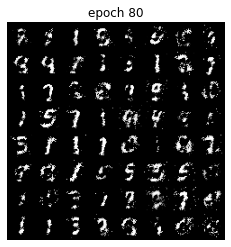

Epoch 80 of 100
Generator loss: 2.42728246, Discriminator loss: 0.67047703


118it [00:52,  2.23it/s]


Epoch 81 of 100
Generator loss: 2.40055036, Discriminator loss: 0.69361760


118it [00:53,  2.21it/s]


Epoch 82 of 100
Generator loss: 2.24256453, Discriminator loss: 0.70597733


118it [00:54,  2.18it/s]


Epoch 83 of 100
Generator loss: 2.15805639, Discriminator loss: 0.72375464


118it [00:55,  2.13it/s]


Epoch 84 of 100
Generator loss: 2.35193150, Discriminator loss: 0.69981796


118it [00:55,  2.14it/s]


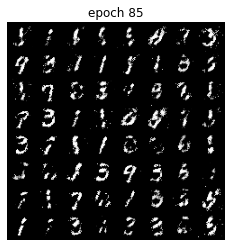

Epoch 85 of 100
Generator loss: 2.30625273, Discriminator loss: 0.70084977


118it [00:55,  2.14it/s]


Epoch 86 of 100
Generator loss: 2.20426452, Discriminator loss: 0.73138040


118it [00:54,  2.16it/s]


Epoch 87 of 100
Generator loss: 2.27778116, Discriminator loss: 0.73001436


118it [00:53,  2.23it/s]


Epoch 88 of 100
Generator loss: 2.19431644, Discriminator loss: 0.73434658


118it [00:54,  2.15it/s]


Epoch 89 of 100
Generator loss: 2.24672400, Discriminator loss: 0.71778670


118it [00:52,  2.24it/s]


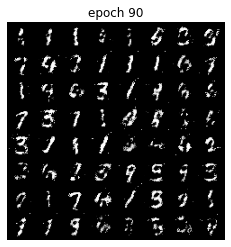

Epoch 90 of 100
Generator loss: 2.20731799, Discriminator loss: 0.73325566


118it [00:52,  2.23it/s]


Epoch 91 of 100
Generator loss: 2.15224073, Discriminator loss: 0.73282782


118it [00:53,  2.22it/s]


Epoch 92 of 100
Generator loss: 2.19597236, Discriminator loss: 0.70680148


118it [00:53,  2.23it/s]


Epoch 93 of 100
Generator loss: 2.00467617, Discriminator loss: 0.79453706


118it [00:52,  2.23it/s]


Epoch 94 of 100
Generator loss: 1.97377153, Discriminator loss: 0.81116214


118it [00:53,  2.22it/s]


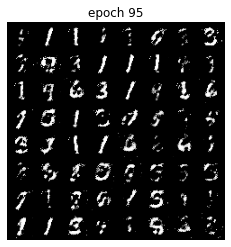

Epoch 95 of 100
Generator loss: 2.05837870, Discriminator loss: 0.78230806


118it [00:51,  2.30it/s]


Epoch 96 of 100
Generator loss: 2.05240402, Discriminator loss: 0.77848106


118it [00:51,  2.30it/s]


Epoch 97 of 100
Generator loss: 1.98682003, Discriminator loss: 0.79692546


118it [00:51,  2.27it/s]


Epoch 98 of 100
Generator loss: 1.90330085, Discriminator loss: 0.81961479


118it [00:50,  2.32it/s]


Epoch 99 of 100
Generator loss: 2.02278254, Discriminator loss: 0.79257844


118it [00:49,  2.37it/s]


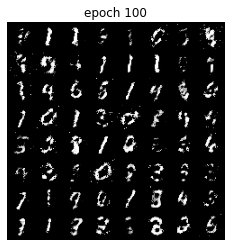

Epoch 100 of 100
Generator loss: 1.94715327, Discriminator loss: 0.81763930


In [15]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 

        #get the input to device
        data[0].to(device)

        # optimize discriminator
        loss_d_total = 0.0
        for _ in range(num_steps_train_discriminator):
          generator_output = generator(create_noise(len(data[0]), nz)).detach() 
          optim_d.zero_grad()
          
          # .detach() to ensure not part of the graph

          #get the preds from discriminator on fake and true data
          gen_disc_output = discriminator(generator_output)
          true_data_output = discriminator(data[0])

          #optimize the loss
          
          disc_loss_fake, disc_loss_real  = discriminator_loss(gen_disc_output, true_data_output) #between fake and true images
          disc_loss_fake.backward()
          disc_loss_real.backward()
          optim_d.step()

          #increase counter
          loss_d_total += (disc_loss_fake+disc_loss_real).detach().cpu().numpy()
    
        # optimize generator
        optim_g.zero_grad()
        generator_output = generator(create_noise(len(data[0]), nz))
        gen_loss = generator_loss(generator_output)
        gen_loss.backward()
        optim_g.step()

        loss_g += gen_loss.detach().cpu().numpy()
        loss_d += loss_d_total / num_steps_train_discriminator
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [16]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [17]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

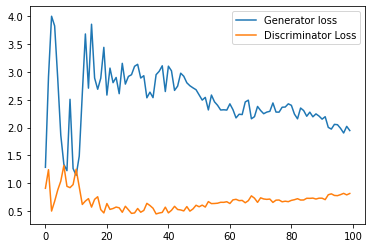

In [18]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')